# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_158  A0A0C4DH31       15.602
Sample_066  A0A075B6H9       18.556
Sample_019  F8W1B7;P50281    15.479
Sample_206  P02753;Q5VY30    20.040
Sample_162  Q16610           17.782
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups                 
Sample_088  A0A0C4DGV4;E9PLX3;O43504;R4GMU8   13.274
Sample_051  H3BRQ4;K4DIB9;P50238               7.534
Sample_059  F8WD41;Q15166                     11.906
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.916
            A0A075B6Q5                 12.608
            A0A075B6R2                 12.632
            A0A075B6S5                 12.763
            A0A087WSY4                 13.340
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.315
            Q9UI40;Q9UI40-2            12.848
            Q9UIW2                     11.384
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.411
            Q9UP79                     12.997
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.742,15.050,16.842,19.863,14.093,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.583,19.067,...,15.528,15.576,11.931,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.997,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.229,17.705,17.039,14.158,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,12.218,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.503,15.345,17.084,18.708,14.249,19.433,10.989,7.723
Sample_207,15.739,16.877,15.469,16.898,12.685,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.916,...,16.012,15.178,13.563,15.050,16.842,19.863,12.485,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.833,19.067,16.188,...,15.528,15.576,11.895,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.822,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.671,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.435,15.345,17.084,18.708,14.249,19.433,13.161,13.755
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 369.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.47it/s]

100%|██████████| 2/2 [00:00<00:00,  5.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.03it/s]

100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.11it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.41it/s]

100%|██████████| 4/4 [00:01<00:00,  2.00it/s]

100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.21it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.79it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.37it/s]

100%|██████████| 5/5 [00:02<00:00,  2.22it/s]

100%|██████████| 5/5 [00:02<00:00,  2.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.58it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.40it/s]

100%|██████████| 6/6 [00:02<00:00,  2.32it/s]

100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.73it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.41it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.17it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.02it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.08it/s]

100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.29it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.49it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.89it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.47it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.27it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.28it/s]

100%|██████████| 8/8 [00:03<00:00,  2.17it/s]

100%|██████████| 8/8 [00:03<00:00,  2.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.21it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.16it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.33it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.13it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.93it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.85it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.09it/s]

100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.90it/s]

 30%|███       | 3/10 [00:00<00:01,  3.92it/s]

 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.49it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.36it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.44it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.58it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.32it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.78it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.09it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.76it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.45it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.08it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.99it/s]

 82%|████████▏ | 9/11 [00:03<00:01,  1.94it/s]

 91%|█████████ | 10/11 [00:04<00:00,  1.98it/s]

100%|██████████| 11/11 [00:04<00:00,  2.08it/s]

100%|██████████| 11/11 [00:04<00:00,  2.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.15it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.50it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.11it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.86it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.85it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.83it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.92it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.04it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.07it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

100%|██████████| 12/12 [00:05<00:00,  2.13it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.03it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.87it/s]

 31%|███       | 4/13 [00:01<00:04,  2.17it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.96it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.96it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.15it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.29it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.46it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.59it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.56it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.42it/s]

100%|██████████| 13/13 [00:05<00:00,  2.58it/s]

100%|██████████| 13/13 [00:05<00:00,  2.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.67it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.47it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.32it/s]

 36%|███▌      | 5/14 [00:02<00:03,  2.33it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.33it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.45it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.53it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.59it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.60it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.69it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.71it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.81it/s]

100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.25it/s]

 20%|██        | 3/15 [00:00<00:03,  3.38it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.62it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.33it/s]

 40%|████      | 6/15 [00:02<00:04,  2.25it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.38it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.45it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.49it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.44it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.51it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.38it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.23it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.12it/s]

100%|██████████| 15/15 [00:06<00:00,  2.05it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.065 0.029          0.735 0.369       0.110   
2             0.006 0.004      0.082 0.028          0.755 0.097       0.619   
3             0.004 0.003      0.055 0.018          0.739 0.099       0.623   
4             0.005 0.004      0.064 0.023          0.775 0.086       0.724   
5             0.005 0.003      0.061 0.020          0.802 0.090       0.775   
6             0.004 0.002      0.052 0.015          0.791 0.093       0.762   
7             0.005 0.004      0.062 0.024          0.790 0.094       0.753   
8             0.005 0.004      0.066 0.031          0.827 0.089       0.812   
9             0.005 0.003      0.060 0.021          0.818 0.078       0.805   
10            0.006 0.004      0.072 0.032          0.805 0.076       0.836   
11            0.005 0.003      0.056 0.021          0.799 0.080       0.833   
12            0.005 0.004      0.058 0.021          0.799 0.083       0.830   
13            0.005 0.004      0.065 0.026          0.803 0.084       0.831   
14            0.006 0.004      0.069 0.025          0.791 0.083       0.805   
15            0.005 0.003      0.063 0.025          0.787 0.078       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.184 0.130                  0.547 0.041        0.854   
2          0.111   0.675 0.087                  0.735 0.062        0.800   
3          0.114   0.669 0.085                  0.729 0.061        0.795   
4          0.112   0.745 0.087                  0.785 0.069        0.866   
5          0.115   0.784 0.088                  0.817 0.072        0.868   
6          0.117   0.772 0.090                  0.807 0.073        0.865   
7          0.123   0.767 0.094                  0.803 0.076        0.864   
8          0.098   0.815 0.075                  0.841 0.065        0.891   
9          0.104   0.808 0.074                  0.836 0.063        0.891   
10         0.099   0.817 0.073                  0.844 0.064        0.907   
11         0.098   0.813 0.073                  0.839 0.063        0.905   
12         0.101   0.811 0.075                  0.838 0.065        0.904   
13         0.103   0.813 0.074                  0.840 0.063        0.903   
14         0.099   0.795 0.073                  0.824 0.062        0.905   
15         0.100   0.792 0.073                  0.822 0.062        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.826 0.093        210.000 0.000  
2          0.070                  0.777 0.088        210.000 0.000  
3          0.073                  0.772 0.088        210.000 0.000  
4          0.061                  0.851 0.070        210.000 0.000  
5          0.067                  0.863 0.068        210.000 0.000  
6          0.067                  0.859 0.070        210.000 0.000  
7          0.067                  0.857 0.070        210.000 0.000  
8          0.062                  0.882 0.070        210.000 0.000  
9          0.062                  0.884 0.066        210.000 0.000  
10         0.052                  0.899 0.054        210.000 0.000  
11         0.054                  0.896 0.056        210.000 0.000  
12         0.054                  0.894 0.057        210.000 0.000  
13         0.054                  0.892 0.058        210.000 0.000  
14         0.052                  0.890 0.059        210.000 0.000  
15         0.052                  0.888 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 448.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.60it/s]

100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

100%|██████████| 3/3 [00:01<00:00,  2.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.93it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.24it/s]

100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.00it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.06it/s]

100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

100%|██████████| 5/5 [00:02<00:00,  2.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.29it/s]

 67%|██████▋   | 4/6 [00:01<00:01,  1.90it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.63it/s]

100%|██████████| 6/6 [00:03<00:00,  1.65it/s]

100%|██████████| 6/6 [00:03<00:00,  1.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.43it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.71it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.45it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.19it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.14it/s]

100%|██████████| 7/7 [00:02<00:00,  2.18it/s]

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.42it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.18it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.55it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.98it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.85it/s]

100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

100%|██████████| 8/8 [00:03<00:00,  2.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.48it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.55it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.44it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.17it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.01it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.07it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.13it/s]

100%|██████████| 9/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:03<00:00,  2.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.34it/s]

 30%|███       | 3/10 [00:00<00:02,  3.11it/s]

 40%|████      | 4/10 [00:01<00:02,  2.25it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.04it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.93it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.07it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.17it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.38it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.73it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.24it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.05it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.01it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.86it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.96it/s]

 82%|████████▏ | 9/11 [00:04<00:00,  2.05it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:05<00:00,  2.20it/s]

100%|██████████| 11/11 [00:05<00:00,  2.19it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.79it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.45it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.08it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.87it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.82it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.85it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.94it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.96it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.09it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  2.14it/s]

100%|██████████| 12/12 [00:05<00:00,  2.17it/s]

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  3.38it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.30it/s]

 31%|███       | 4/13 [00:01<00:04,  1.95it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.96it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.97it/s]

 54%|█████▍    | 7/13 [00:03<00:02,  2.06it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.15it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.23it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.29it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.36it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.38it/s]

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.68it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.44it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.10it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.14it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.28it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.35it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.44it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.45it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.39it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.35it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.31it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.33it/s]

100%|██████████| 14/14 [00:05<00:00,  2.35it/s]

100%|██████████| 14/14 [00:05<00:00,  2.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:04,  3.09it/s]

 20%|██        | 3/15 [00:01<00:05,  2.22it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.04it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.12it/s]

 40%|████      | 6/15 [00:02<00:04,  2.20it/s]

 47%|████▋     | 7/15 [00:03<00:03,  2.28it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.29it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.29it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.24it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.25it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.42it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.46it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.01it/s]

100%|██████████| 15/15 [00:06<00:00,  1.83it/s]

100%|██████████| 15/15 [00:06<00:00,  2.15it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.004      0.082 0.026          0.858 0.237       0.154   
2             0.005 0.005      0.060 0.022          0.629 0.109       0.550   
3             0.004 0.003      0.063 0.028          0.774 0.076       0.734   
4             0.005 0.003      0.061 0.022          0.774 0.088       0.733   
5             0.004 0.001      0.054 0.026          0.772 0.088       0.755   
6             0.006 0.004      0.065 0.026          0.783 0.085       0.774   
7             0.007 0.007      0.072 0.025          0.846 0.079       0.831   
8             0.005 0.003      0.053 0.014          0.844 0.079       0.829   
9             0.005 0.003      0.055 0.015          0.837 0.084       0.816   
10            0.005 0.004      0.055 0.019          0.847 0.081       0.822   
11            0.005 0.007      0.056 0.015          0.850 0.076       0.834   
12            0.005 0.003      0.056 0.018          0.848 0.081       0.845   
13            0.005 0.003      0.054 0.021          0.847 0.080       0.842   
14            0.004 0.001      0.053 0.013          0.846 0.079       0.839   
15            0.007 0.004      0.077 0.032          0.847 0.080       0.839   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.090   0.252 0.128                  0.569 0.043        0.854   
2          0.117   0.580 0.097                  0.654 0.070        0.740   
3          0.101   0.750 0.073                  0.788 0.059        0.870   
4          0.109   0.748 0.074                  0.786 0.060        0.880   
5          0.105   0.759 0.078                  0.794 0.064        0.879   
6          0.093   0.773 0.060                  0.806 0.050        0.883   
7          0.089   0.835 0.063                  0.859 0.052        0.903   
8          0.089   0.832 0.061                  0.857 0.051        0.902   
9          0.099   0.822 0.069                  0.848 0.057        0.900   
10         0.096   0.830 0.067                  0.855 0.057        0.919   
11         0.093   0.839 0.066                  0.862 0.057        0.923   
12         0.091   0.843 0.066                  0.865 0.057        0.925   
13         0.096   0.841 0.068                  0.864 0.058        0.925   
14         0.103   0.838 0.069                  0.862 0.059        0.930   
15         0.101   0.838 0.065                  0.862 0.056        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.072                  0.684 0.089        210.000 0.000  
3          0.050                  0.846 0.061        210.000 0.000  
4          0.047                  0.851 0.061        210.000 0.000  
5          0.051                  0.855 0.061        210.000 0.000  
6          0.050                  0.864 0.060        210.000 0.000  
7          0.050                  0.897 0.048        210.000 0.000  
8          0.050                  0.896 0.048        210.000 0.000  
9          0.053                  0.894 0.052        210.000 0.000  
10         0.047                  0.906 0.050        210.000 0.000  
11         0.045                  0.905 0.052        210.000 0.000  
12         0.045                  0.906 0.053        210.000 0.000  
13         0.046                  0.908 0.057        210.000 0.000  
14         0.044                  0.915 0.053        210.000 0.000  
15         0.043                  0.913 0.051 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 947.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.51it/s]

100%|██████████| 3/3 [00:00<00:00, 12.83it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.80it/s]

100%|██████████| 4/4 [00:00<00:00, 13.15it/s]

100%|██████████| 4/4 [00:00<00:00, 13.64it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.54it/s]

100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

100%|██████████| 5/5 [00:00<00:00, 12.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 14.40it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 10.76it/s]

100%|██████████| 6/6 [00:00<00:00, 10.84it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.51it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.50it/s]

100%|██████████| 7/7 [00:00<00:00, 16.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.53it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 14.80it/s]

100%|██████████| 8/8 [00:00<00:00, 13.52it/s]

100%|██████████| 8/8 [00:00<00:00, 13.96it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 16.12it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.35it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.25it/s]

100%|██████████| 9/9 [00:00<00:00, 10.67it/s]

100%|██████████| 9/9 [00:00<00:00, 11.20it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.83it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.73it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.90it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.45it/s]

100%|██████████| 10/10 [00:00<00:00, 14.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.25it/s]

 36%|███▋      | 4/11 [00:00<00:00,  9.64it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  8.58it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  7.98it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.09it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  8.49it/s]

100%|██████████| 11/11 [00:01<00:00,  9.62it/s]

100%|██████████| 11/11 [00:01<00:00,  9.17it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 18.97it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.85it/s]

 50%|█████     | 6/12 [00:00<00:00,  8.72it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.12it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  7.59it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  7.54it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  7.77it/s]

100%|██████████| 12/12 [00:01<00:00,  7.83it/s]

100%|██████████| 12/12 [00:01<00:00,  8.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.22it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.34it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.83it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 10.24it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.82it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.79it/s]

100%|██████████| 13/13 [00:01<00:00, 10.56it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.64it/s]

 36%|███▌      | 5/14 [00:00<00:00, 12.51it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.99it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 10.34it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.44it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.66it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.14it/s]

100%|██████████| 14/14 [00:01<00:00,  9.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 17.22it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.36it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.04it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.02it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.82it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.73it/s]

100%|██████████| 15/15 [00:01<00:00, 12.57it/s]

100%|██████████| 15/15 [00:01<00:00, 13.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.078 0.031          0.310 0.451       0.021   
2             0.005 0.005      0.055 0.018          0.686 0.123       0.350   
3             0.005 0.003      0.076 0.028          0.581 0.109       0.453   
4             0.005 0.005      0.063 0.029          0.621 0.142       0.454   
5             0.004 0.000      0.048 0.007          0.609 0.139       0.451   
6             0.005 0.003      0.059 0.022          0.593 0.132       0.437   
7             0.005 0.005      0.066 0.024          0.577 0.111       0.430   
8             0.004 0.001      0.055 0.019          0.590 0.115       0.432   
9             0.004 0.001      0.050 0.017          0.574 0.100       0.431   
10            0.006 0.005      0.091 0.034          0.562 0.097       0.435   
11            0.005 0.003      0.054 0.016          0.556 0.105       0.430   
12            0.005 0.004      0.063 0.026          0.542 0.100       0.427   
13            0.006 0.005      0.068 0.028          0.533 0.098       0.426   
14            0.005 0.004      0.062 0.024          0.522 0.105       0.431   
15            0.006 0.005      0.083 0.033          0.600 0.084       0.561   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.030   0.038 0.056                  0.508 0.015        0.728   
2          0.083   0.455 0.079                  0.611 0.045        0.662   
3          0.107   0.500 0.088                  0.602 0.063        0.674   
4          0.109   0.513 0.096                  0.617 0.068        0.687   
5          0.111   0.507 0.101                  0.612 0.069        0.679   
6          0.111   0.491 0.096                  0.601 0.065        0.670   
7          0.112   0.483 0.087                  0.595 0.059        0.662   
8          0.098   0.491 0.083                  0.601 0.060        0.661   
9          0.100   0.487 0.091                  0.598 0.062        0.653   
10         0.099   0.486 0.087                  0.593 0.060        0.643   
11         0.107   0.480 0.096                  0.589 0.066        0.636   
12         0.101   0.473 0.091                  0.582 0.062        0.630   
13         0.105   0.468 0.091                  0.577 0.063        0.628   
14         0.109   0.465 0.089                  0.569 0.061        0.626   
15         0.111   0.574 0.081                  0.643 0.060        0.705   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.678 0.075        210.000 0.000  
2          0.076                  0.617 0.084        210.000 0.000  
3          0.084                  0.592 0.091        210.000 0.000  
4          0.075                  0.612 0.085        210.000 0.000  
5          0.074                  0.605 0.081        210.000 0.000  
6          0.073                  0.592 0.082        210.000 0.000  
7          0.071                  0.592 0.083        210.000 0.000  
8          0.069                  0.589 0.078        210.000 0.000  
9          0.072                  0.582 0.078        210.000 0.000  
10         0.074                  0.576 0.075        210.000 0.000  
11         0.074                  0.570 0.074        210.000 0.000  
12         0.074                  0.564 0.073        210.000 0.000  
13         0.073                  0.559 0.073        210.000 0.000  
14         0.071                  0.564 0.077        210.000 0.000  
15         0.060                  0.620 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,2,7,10
score_time,2,1,10
test_precision,8,1,2
test_recall,10,12,15
test_f1,10,12,15
test_balanced_accuracy,10,12,15
test_roc_auc,10,14,1
test_average_precision,10,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.60it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.30it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.91it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.67it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.14it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.03it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.83it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.74it/s]

 71%|███████▏  | 10/14 [00:05<00:02,  1.54it/s]

 79%|███████▊  | 11/14 [00:05<00:02,  1.49it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.55it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.60it/s]

100%|██████████| 14/14 [00:07<00:00,  1.76it/s]

100%|██████████| 14/14 [00:07<00:00,  1.91it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 905.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.92it/s]

 30%|███       | 3/10 [00:01<00:02,  2.60it/s]

 40%|████      | 4/10 [00:01<00:02,  2.16it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.04it/s]

 60%|██████    | 6/10 [00:02<00:02,  2.00it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.14it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.36it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.17it/s]

100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


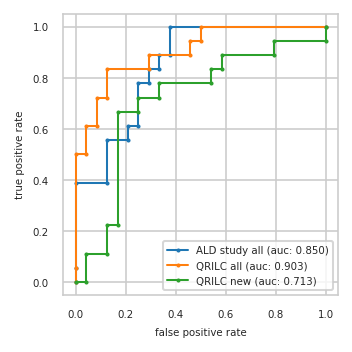

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.389     0.000 0.500     0.042 0.111
3          0.125 0.389     0.042 0.500     0.125 0.111
4          0.125 0.556     0.042 0.611     0.125 0.222
5          0.208 0.556     0.083 0.611     0.167 0.222
6          0.208 0.611     0.083 0.722     0.167 0.667
7          0.250 0.611     0.125 0.722     0.250 0.667
8          0.250 0.778     0.125 0.833     0.250 0.722
9          0.292 0.778     0.292 0.833     0.333 0.722
10         0.292 0.833     0.292 0.889     0.333 0.778
11         0.333 0.833     0.458 0.889     0.542 0.778
12         0.333 0.889     0.458 0.944     0.542 0.833
13         0.375 0.889     0.500 0.944     0.583 0.833
14         0.375 1.000     0.500 1.000     0.583 0.889
15         1.000 1.000     1.000 1.000     0.792 0.889
16           NaN   NaN       NaN   NaN     0.792 0.944
17           NaN   NaN       NaN   NaN     1.000 0.944
18           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
1,B0QYF8;P02144,O75326,None
2,G3XAP6;P49747;P49747-2,P60709;P63261,None
3,P02766,Q96MK3,None
4,P61981,P61981,None
5,P04075,Q9Y2T3;Q9Y2T3-3,None
6,P14174,P04075,None
7,Q9Y2T3;Q9Y2T3-3,P14174,None
8,P00338;P00338-3,P08294,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


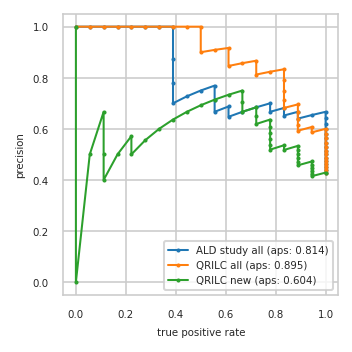

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.415 0.944
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.533 0.889
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.667 1.000     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.538 0.778
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.652 0.833     0.696 0.889     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.667 0.778     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.684 0.722     0.789 0.833     0.684 0.722
24         0.667 0.667     0.833 0.833     0.667 0.667
25         0.647 0.611     0.824 0.778     0.706 0.667
26         0.688 0.611     0.812 0.722     0.750 0.667
27         0.667 0.556     0.867 0.722     0.733 0.611
28         0.714 0.556     0.857 0.667     0.714 0.556
29         0.769 0.556     0.846 0.611     0.692 0.500
30         0.750 0.500     0.917 0.611     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


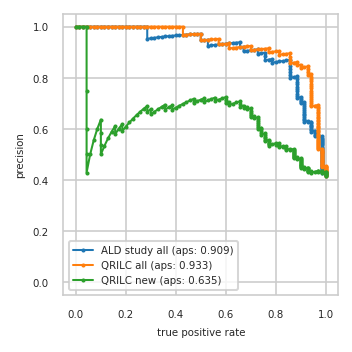

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


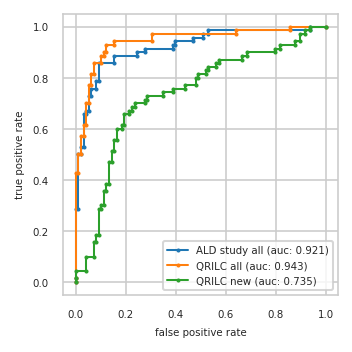

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}